In [ ]:
import os
%load_ext autoreload
%autoreload 2
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import json
import numpy as np
#import rpy2.robjects as robjects
#from rpy2.robjects import r, pandas2ri
#from rpy2.robjects.packages import importr
from matplotlib.ticker import MaxNLocator
from os.path import exists
import pickle
from scipy.stats import sem
import statistics
import scipy
from sklearn.metrics import mean_squared_error
from kneed import KneeLocator
import math


### 'data_sf' is human players in self finding studies
### 'keep_close' is the proximity baseline
### 'human_extended' is the perturbation study for humans

colors = {"human": "#000000", "data_sf": "#8a3a01", "human_extended": "#525151", "self_class": "#19c202", "self_class_include_perturbation": "#19c202",
          "keep_close": "#0f7801", "self_classshort": "#19c202",
          "random": "#9c2200", "a2c_training": "#89CFF0",
          "trpo_training": "#0000FF",
          "acer_training": "#7393B3", "acer_training2": "#0096FF", "acer_trainingeasy": "#9c2200", "ppo2_training": "#0096FF", "dqn_training": "#5D3FD3", "option_critic": "#23dedb"}

game_titles = {
    "shuffleKeys_game": "Switching Mappings Keys Game",
    "shuffleKeys_game_final": "Switching Mappings Keys Game",
    "contingency_game": "Contingency Game",
    "contingency_game_final": "Contingency Game",
    "contingency_game_0": "Contingency Game (Single Seed)",
    "contingency_game_lrtest": "Contingency Game (Single Seed)",
    "contingency_game_r0": "Contingency Game (Agent Placement is Constant Among Each Level)",
    "contingency_game_diff_color": "Contingency Game (Real Agent is Blue)",
    "contingency_game_shuffled": "Switching Mappings Game (Switched Once in Every 200 Levels)",
    "contingency_game_shuffled_1": "Switching Mappings Game (Switched Every Level)",
    "contingency_game_shuffled_100": "Switching Mappings Game (Switched Once in Every 100 Levels)",
    "contingency_game_shuffled_200": "Switching Mappings Game (Switched Once in Every 200 Levels)",
    "contingency_game_shuffled_final": "Switching Mappings Game (Switched Once in Every 200 Levels)",
    "contingency_game_shuffled_1_final": "Switching Mappings Game (Switched Every Level)",
    "contingency_game_shuffled_100_final": "Switching Mappings Game (Switched Once in Every 100 Levels)",
    "contingency_game_shuffled_200_final": "Switching Mappings Game (Switched Once in Every 200 Levels)",
    "logic_game": "Logic Game",
    "logic_game_final": "Logic Game",
    "logic_game_0": "Logic Game",
    "logic_game_lrtest": "Logic Game",
    "logic_include_perturbation_game": "Logic Game (Modified After 2000 Levels)",
    "change_agent_game": "Switching Embodiments Game",
    "change_agent_game_final": "Switching Embodiments Game",
    "change_agent_game_lrtest": "Switching Embodiments Game (Single Seed)"
}

label_dict = {'human': 'Human', 'data_sf': 'Human (Self-Finding)', 'human_extended': 'Human include_perturbation',
              'self_class': 'Self Class', 'self_class_include_perturbation': 'Self Class', 'self_classshort': 'Self Class', 'dqn_training': 'DQN',
              'random': 'Random', 'a2c_training': "A2C", 'trpo_training': 'TRPO', 'ppo2_training': 'PPO2',
              'acer_training': 'ACER', 'acer_training2': 'ACER (New Version)', 'acer_trainingeasy': 'ACER (Easy Version)', "option_critic": "OC", "keep_close": "Keeping Close"}


def find_between(s, first, last):
    try:
        start = s.index(first) + len(first)
        end = s.index(last, start)
        return s[start:end]
    except ValueError:
        return ""


def get_seed_num_and_iter(x):
    if "seed" in x:
        return int(find_between(x.split("/")[4], "seed", "-")) * 1000000000 + int(x.split("/")[-1][6:-5])
    else:
        if "short" in x:
            return int(x.split("/")[4].split("iter")[1]) * 1000000000 + int(x.split("/")[-1][11:-5])
        else:
            return int(x.split("/")[4].split("iter")[1]) * 1000000000 + int(x.split("/")[-1][6:-5])


In [ ]:

def cosmetic_change(game_type, ax, axes, last_100, agent_types, only_first_100, perturbated, avg_per_n_steps):
    if game_type == 'contingency_game_shuffled':
        axes.set_ylim([0, 6000])
    elif game_type == 'change_agent_game':
        axes.set_ylim([0, 750])
    elif game_type in ['contingency_game', 'contingency_game_diff_color', 'contingency_game_0',
                       ]:
        if not last_100:
            axes.set_ylim([0, 800])
    elif game_type == "contingency_game_shuffled_200":
        axes.set_ylim([0, 4000])
    elif game_type in ["contingency_game_shuffled_100", "contingency_game_shuffled_1"]:
        axes.set_ylim([0, 6000])
        if game_type == "contingency_game_shuffled_1" and last_100:
            axes.set_ylim([0, 2000])
    elif game_type == 'logic_game':
        axes.set_ylim([0, 100])
    elif game_type == 'change_agent_game_harder_2':
        axes.set_ylim([0, 200])

    if perturbated and game_type in ['contingency_game']:
        axes.set_ylim([0, 600])

    if only_first_100 and (("self_class" in agent_types) and ("human" in agent_types)):
        axes.set_xlim([0, 120])
        axes.set_ylim([0, 13]) if game_type == 'logic_game' else axes.set_ylim([0, 50])
        if game_type == "change_agent_game":
            axes.set_ylim([0, 160])

    if only_first_100:
        axes.set_xlim([0, 100])
            

    if only_first_100 and perturbated:
        if game_type == "change_agent_game":
            axes.set_xlim([0, 30])
        else:
            axes.set_xlim([0, 150])

    if last_100 and game_type == "contingency_game":
        axes.set_ylim([0, 50])
    elif last_100 and game_type == "change_agent_game":
        axes.set_ylim([0, 160])
    elif only_first_100 and game_type in ["change_agent_game", "change_agent_game_harder"] and perturbated:
        axes.set_ylim([0, 325])
    elif last_100 and game_type == "contingency_game_shuffled_100":
        axes.set_ylim([0, 2500])
    elif (only_first_100 or last_100) and game_type == "logic_game":
        axes.set_ylim([0, 20])
    elif only_first_100 and game_type == 'contingency_game':
        axes.set_ylim([0, 50])

    y_str = "No. Steps To Complete Level" + '\nAveraged Every {} Levels'.format(avg_per_n_steps)
    if avg_per_n_steps == 1:
        y_str = "No. Steps To Complete Level"

    if game_type == "contingency_game_shuffled_1" and only_first_100:
        axes.set_ylim([0, 50])

    if not only_first_100 and not last_100:
        ax.set_ylabel(ylabel=y_str, labelpad=21, fontsize=25)
        ax.set_xlabel(xlabel="Levels Played", labelpad=21, fontsize=25)
        ax.tick_params(axis='both', which='major', labelsize=27)
    else:
        ax.tick_params(axis='both', which='major', labelsize=40)

def plot_error_line(err_mean):
    SMALL_SIZE = 13 * 9/10
    MEDIUM_SIZE = 20 * 9/10
    BIGGER_SIZE = 24 * 9/10

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE + 1)  # fontsize of the figure title

    xs = np.linspace(1, 9, num=9)
    plt.figure()

    kneedle = KneeLocator(xs, list(err_mean.values()), S=1.0, curve="convex", direction="decreasing")
    print("Error elbow: ", kneedle.elbow)

    plt.plot(xs, list(err_mean.values()))
    plt.ylabel("Error", fontweight='bold')
    plt.xlabel("Degree", fontweight='bold')

    plt.tight_layout()


    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.savefig("./plots/err.png", dpi=1000)

# avg_per_n_steps = Average per N levels
# single_seed=True plots only a single seed (For testing)
def get_performance(game_type, agent_types, avg_per_n_steps=10, single_seed=False, include_perturbation=False, find_elbow=False):
    game_types = [game_type]
    param_dict = {}; param_dict[game_type] = {}
    
    # Check if saved data exists
    loaded = {}
    for agent_type in agent_types:
        loaded[agent_type] = False
        fpath = './plotting_data/{}_'.format(game_type) + agent_type + "{}".format("_ext" if include_perturbation else "") + ".pickle"
        if exists(fpath):
            loaded[agent_type] = True
            param_dict[game_type][agent_type] = pickle.load(open(fpath, 'rb'))
            print("Loaded {}...".format(agent_type))
        else:
            print("Will read {}...".format(agent_type))
            

    if include_perturbation:
        target_file_count = 40
    else:
        target_file_count = 20

    target_file_count_o = target_file_count

    ## ----- Read in data
    for agent_type in agent_types:
        if agent_type == "self_classshort":
            target_file_count = 2
        else:
            target_file_count = target_file_count_o

        if loaded[agent_type]:
            continue

        files_o = glob.glob("../data/" + game_type + "/" + agent_type + "/*/*.json")
        if len(files_o) == 0:
            files_o = glob.glob("../data/" + game_type + "/" + agent_type + "/*.json")

        files = files_o
        # Skip stress test files
        if not include_perturbation and agent_type not in ["human", "data_sf", "human_extended", "random"]:
            files = []
            for x in files_o:
                if 'short' in x:
                    if int(x.split("/")[-1][11:-5]) <= 1900:
                        files.append(x)

                else:
                    if int(x.split("/")[-1][6:-5]) <= 1900:
                        files.append(x)

        seed = 0
        curr_file_count = 0
        file_amt = len(files)
        param_dict[game_type][agent_type] = {}
        seed_current = []
        all_seeds = []
        seed_total = 20 if not single_seed else 1

        if game_type in ['change_agent_game', 'change_agent_game_harder', 'change_agent_game_harder_2']:
            seed_total = 18

        if game_type in ['contingency_game_shuffled_100', 'contingency_game_shuffled_200']:
            seed_total = 10

        if single_seed:
            seed_total = 1

        sorted_files = sorted(files, key=os.path.getmtime if agent_type in ['human', 'data_sf',
                                                                            'human_extended'] else get_seed_num_and_iter)
        for i, file in enumerate(sorted_files):
            with open(file, 'r') as fp:
                print("Getting ", file, "...")
                data = json.load(fp)
                param_dict[game_type][agent_type] = data['data']['steps']
                curr_file_count += 1

                seed_current.append(data['data']['steps'])

                if agent_type in ['human', 'data_sf', 'human_extended'] and (file_amt == 1 or single_seed):
                    param_dict[game_type][agent_type] = [data['data']['steps']]
                    break
                else:
                    if agent_type in ['human', 'data_sf', 'human_extended'] and curr_file_count == file_amt:
                        param_dict[game_type][agent_type] = seed_current
                        break

                if agent_type != 'human' and curr_file_count == target_file_count:
                    all_seeds.append(seed_current)
                    seed_current = []
                    curr_file_count = 0
                    seed += 1

                if seed == seed_total:
                    print("Seed total: ", seed)
                    print("Saving")
                    param_dict[game_type][agent_type] = all_seeds
                    all_seeds = []

                    if single_seed:
                        break

        # Save data of current agent
        with open('./plotting_data/{}_'.format(game_type) + agent_type + "{}".format("_ext" if include_perturbation else "") + ".pickle", 'wb') as f:
            print("Saving {}...".format(agent_type)); pickle.dump(param_dict[game_type][agent_type], f)
        print("Passing from {} to Next agent".format(agent_type))

    ## ---- Get descriptive statistics
    stats_dict = {}
    stats_dict[game_type] = {}
    for agent_type in agent_types:
        print(agent_type)
        raw_data = pd.DataFrame(param_dict[game_type][agent_type])

        seed_average = []
        seed_sem = []
        for column in raw_data:
            seed_average.append(np.mean(list(raw_data[column]), axis=0))
            seed_sem.append((pd.DataFrame(list(raw_data[column]))).sem(axis=0))

        curr_avg_data = pd.DataFrame(seed_average).T
        curr_sem_data = pd.DataFrame(seed_sem).T
        stats_dict[game_type][agent_type] = raw_data

        # Fit a curve to human line, and use the elbow method to find the point of stabilization
        if agent_type == "human":
            errors = {}
            def get_best_degree():
                np.random.seed(0)
                xs = list(range(0, 100))
                ys = list(curr_avg_data.T[0])

                from sklearn.linear_model import LinearRegression
                from sklearn.preprocessing import PolynomialFeatures
                from sklearn.metrics import mean_squared_error
                from sklearn.model_selection import train_test_split

                rmses = {} # Degree is key, RMSE is value
                for i in range(0, 100):
                    x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.3)
                    degrees = np.arange(1, 15)
                    min_rmse, min_deg = 0, 0

                    for deg in degrees:
                        if deg not in list(rmses.keys()):
                            rmses[deg] = []

                        # Train features
                        poly_features = PolynomialFeatures(degree=deg, include_bias=False)
                        x_poly_train = poly_features.fit_transform(np.array(x_train).reshape(-1, 1))

                        # Linear regression
                        poly_reg = LinearRegression()
                        poly_reg.fit(x_poly_train, y_train)

                        # Compare with test data
                        x_poly_test = poly_features.fit_transform(np.array(x_test).reshape(-1, 1))
                        poly_predict = poly_reg.predict(x_poly_test)
                        poly_mse = mean_squared_error(y_test, poly_predict)
                        poly_rmse = np.sqrt(poly_mse)
                        rmses[deg].append(poly_rmse)

                # Plot and present results
                min_rmse = statistics.mean(rmses[1])
                min_deg = 1
                    
                rmse_means = []
                for i in range(1, 15):
                    if statistics.mean(rmses[i]) < min_rmse:
                        min_deg = i
                        min_rmse = statistics.mean(rmses[i])

                    rmse_means.append(statistics.mean(rmses[i]))

                print('Best degree {} with RMSE {}'.format(min_deg, min_rmse))
                        
                fig = plt.figure()
                ax = fig.add_subplot(111)
                ax.plot(degrees, rmse_means)
                ax.set_yscale('log')
                ax.set_xlabel('Degree')
                ax.set_ylabel('RMSE')
                plt.show()

            def plot_curve(deg=20):
                xs = list(range(0, 100))
                ys = list(curr_avg_data.T[0])
                fitted_poly = np.polyfit(xs, ys, deg=deg)

                y_fitted = np.polyval(fitted_poly, xs)
                kneedle = KneeLocator(xs, y_fitted, S=1.0, curve="convex", direction="decreasing")
                print(kneedle.elbow)

                plt.plot(xs, ys)
                plt.plot(xs, y_fitted)
                plt.show()
                
                plt.cla()
                plt.clf()

                kneedle.plot_knee()

                plt.cla()
                plt.clf()

            if find_elbow:
                plot_curve(deg=3)
                get_best_degree()

        if agent_type not in ['human', 'data_sf', 'human_extended']:  # Average per N levels for AI
            stats_dict[game_type][agent_type + "_m"] = np.array(
                [curr_avg_data[column].groupby(curr_avg_data.index // avg_per_n_steps).mean() for column in
                    curr_avg_data]).reshape(
                int(curr_avg_data.shape[1] * 100 * 1 / avg_per_n_steps))
            stats_dict[game_type][agent_type + "_se"] = np.array(
                [curr_sem_data[column].groupby(curr_sem_data.index // avg_per_n_steps).mean() for column in
                    curr_sem_data]).reshape(
                int(curr_sem_data.shape[1] * 100 * 1 / avg_per_n_steps))
        else:  # Average per N levels for Human data
            if agent_type in ['human', 'human_extended'] and include_perturbation and avg_per_n_steps != 1:
                c_avg_per_n_steps = 1
            else:
                c_avg_per_n_steps = avg_per_n_steps
                
            temp = np.asarray(curr_avg_data).T
            avg_ma = [temp[i:i + c_avg_per_n_steps].mean() for i in
                        range(0, curr_avg_data.shape[1] - c_avg_per_n_steps + 1, c_avg_per_n_steps)]

            temp = np.asarray(curr_sem_data).T
            avg_se = [temp[i:i + c_avg_per_n_steps].mean() for i in
                        range(0, curr_sem_data.shape[1] - c_avg_per_n_steps + 1, c_avg_per_n_steps)]

            stats_dict[game_type][agent_type + "_m"] = np.array(avg_ma).reshape(
                int(curr_avg_data.shape[1] / c_avg_per_n_steps))
            stats_dict[game_type][agent_type + "_se"] = np.array(avg_se).reshape(
                int(curr_sem_data.shape[1] / c_avg_per_n_steps))

    return stats_dict


# perturbated=True: Plots the stress tests
# only_first_100=True: Plots only the first hundred
# last_100=True: Plots only the last hundred
def plotter(stats, game_type, agent_types, avg_per_n_steps, perturbated=False, only_first_100=False, last_100=False, save_data=False):
    st = stats[game_type]
    
    for i, a in enumerate(agent_types):
        
        ## Saving data files for t-tests and BF's
        if perturbated:  
            if i == 0:
                after_perturbation = {}          
            if a not in ['human', 'data_sf', 'human_extended']:
                after_perturbation[a + "_all"] = list(np.asarray(st[a].T.explode([i for i in range(0, st[a].shape[0])]).mean(axis=1).T))
                after_perturbation[a + "_averaged"] = list(np.average(np.asarray(st[a].T.explode([i for i in range(0, st[a].shape[0])]).mean(axis=1)).reshape(-1, 40), axis=1))
            else:
                after_perturbation["human"] = list(np.asarray(st[a].T.explode([i for i in range(0, st[a].shape[0])]).mean(axis=1).T))

        else:
            if i == 0:
                jdata = {}

            if a in ['human', 'data_sf', 'human_extended']:
                jdata[a] = st[a].T.values.tolist()
                jdata[a + '_avg'] = np.mean(st[a + '_m'])
            else:
                jdata[a + '_first_150'] = np.asarray([t[:150] for t in (
                            list(st[a].iloc[:, 0:].values.T)[0] + list(st[a].iloc[:, 0:].values.T)[1])]).T.tolist()
                jdata[a + '_first_150_avg'] = np.mean(st[a + '_m'][:150])
                jdata[a + '_last_100'] = np.asarray([t[:100] for t in list(st[a].iloc[:, -1:].values.T)[0]]).T.tolist()
                jdata[a + '_last_100_avg'] = np.mean(st[a + '_m'][-100:])

                if game_type == "logic_game" and avg_per_n_steps == 1:
                    jdata[a + '_all'] = list(st[a + '_m'])


    fig, ax = plt.subplots(figsize=(20, 10))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    axes = plt.gca()

    ##### Cosmetic #####
    cosmetic_change(game_type, ax, axes, last_100, agent_types, only_first_100, perturbated, avg_per_n_steps)

    for j, agent_type in enumerate(agent_types):  # Plot each line
        if agent_type not in ['human', 'data_sf', 'human_extended']:  # Algorithms

            xs = [int(i * avg_per_n_steps) for i in range(0, len(st[agent_type + "_m"]))]
            temp_xs = []
            if last_100:
                for a in xs:
                    if a < 100:
                        temp_xs.append(a)
                xs = temp_xs
                r_l = ax.plot(xs, st[agent_type + "_m"][-int(100 / avg_per_n_steps):], color=colors[agent_type],
                              linewidth=4 if agent_type == "self_class" else 1,
                              label=label_dict[agent_type])
                ax.fill_between(xs, st[agent_type + "_m"][-int(100 / avg_per_n_steps):] - st[agent_type + "_se"][
                                                                                     -int(100 / avg_per_n_steps):],
                                st[agent_type + "_m"][-int(100 / avg_per_n_steps):] + st[agent_type + "_se"][
                                                                                 -int(100 / avg_per_n_steps):],
                                alpha=0.08, color=colors[agent_type])
            else:
                if "self_class" in agent_type:
                    r_l = ax.plot(xs, st[agent_type + "_m"], color=colors[agent_type],
                                  linewidth=4 if only_first_100 or last_100 else 2,
                                  label=label_dict[agent_type])
                else:
                    r_l = ax.plot(xs, st[agent_type + "_m"], color=colors[agent_type], linewidth=1,
                                  label=label_dict[agent_type])
                ax.fill_between(xs, st[agent_type + "_m"] - st[agent_type + "_se"],
                                st[agent_type + "_m"] + st[agent_type + "_se"], alpha=0.08,
                                color=colors[agent_type])
        else:  # Human
            if agent_type in ['human', 'human_extended'] and perturbated and avg_per_n_steps != 1:
                c_avg_per_n_steps = 1
            else:
                c_avg_per_n_steps = avg_per_n_steps
            xs = [int(i * c_avg_per_n_steps) for i in range(0, len(st["{}_m".format(agent_type)]))]
            if last_100:
                hum_l = ax.plot(xs, st['{}_m'.format(agent_type)], color=colors[agent_type], linewidth=2,
                                label=label_dict[agent_type], linestyle='dashed', zorder=9999)
            else:
                hum_l = ax.plot(xs, st['{}_m'.format(agent_type)], color=colors[agent_type], linewidth=2,
                                label=label_dict[agent_type], zorder=9999)
            x = [int(i * c_avg_per_n_steps) for i in range(0, len(st["{}_m".format(agent_type)]))]
            ax.fill_between(x, st['{}_m'.format(agent_type)] - st['{}_se'.format(agent_type)],
                            st['{}_m'.format(agent_type)] + st['{}_se'.format(agent_type)],
                            alpha=0.08, color=colors[agent_type])
    plt.tight_layout()
    if perturbated:
        if "human_extended" in agent_types:
            if game_type == "change_agent_game":
                if only_first_100:
                    plt.axvline(x=20, color="#ffff03", alpha=0.2, linewidth=15)
                else:
                    plt.axvline(x=2000, color="#ffff03", alpha=0.2, linewidth=15)
            else:
                plt.axvline(x=100, color="#ffff03", alpha=0.2, linewidth=15) if only_first_100 else plt.axvline(x=2000,
                                                                                                                color="#ffff03",
                                                                                                                alpha=0.2,
                                                                                                                linewidth=15)
        else:
            plt.axvline(x=2000, color="#ffff03", alpha=0.2, linewidth=15)

    #leg = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title_fontsize=25)
    #plt.rc('legend', fontsize=25)

    #for legobj in leg.legendHandles:
    #    legobj.set_linewidth(6.0)

    # For plotting bayes lines
    bfs = {}

    try:
        if only_first_100:
            f = open("../stats/{}_bfs.json".format(game_type))
            bfs[game_type] = json.load(f)[game_type]["perturbated" if perturbated else "normal"]
            bf = bfs[game_type]

            for x, s in enumerate(bf):
                if s == 1:
                    if game_type == "logic_game":
                        ax.hlines(xmin=max(0, x - 0.5), xmax=x + 0.5, y=17, linewidth=12, color="#0373fc")
                    elif game_type == "contingency_game":
                        ax.hlines(xmin=max(0, x - 0.5), xmax=x + 0.5, y=45, linewidth=12, color="#0373fc")
                    elif game_type in ["change_agent_game", "change_agent_game_harder"]:
                        if perturbated:
                            ax.hlines(xmin=max(0, x - 0.5), xmax=x + 0.5, y=300, linewidth=12, color="#0373fc")
                        else:
                            ax.hlines(xmin=max(0, x - 0.5), xmax=x + 0.5, y=150, linewidth=12, color="#0373fc")
                    elif game_type == "contingency_game_shuffled_1":
                        ax.hlines(xmin=max(0, x - 0.5), xmax=x + 0.5, y=45, linewidth=12, color="#0373fc")
    except:
        print("No bf")

    path = './plots/{}/'.format(game_type)
    if not os.path.exists(path):
        os.makedirs(path)

    # Human vs. Self
    hs = ''
    if only_first_100 and (("self_class" in agent_types) and ("human" in agent_types)):
        hs = '_human_vs_self'


    if not save_data:
        plt.show()
        fig.savefig(
            path + 'effiency_curves_' + game_type + '{}{}{}{}{}.pdf'.format('_' + str(avg_per_n_steps),
                                                                            '_first_100' if only_first_100 else '',
                                                                            '_last_100' if last_100 else '',
                                                                            '_perturbated' if perturbated else '',
                                                                            hs),
            format='pdf',
            bbox_inches="tight")

    if save_data and perturbated:
        try:
            with open('../stats/data_{}_after_perturbation.json'.format(game_type), 'w+') as fp:  # Save data files
                json.dump(after_perturbation, fp, indent=4)
        except Exception as e:
            print(e)

    if save_data and not perturbated:
        try:
            with open('../stats/data_{}.json'.format(game_type), 'w+') as fp:  # Save data files
                print("*** Saving: ", jdata)
                json.dump(jdata, fp, indent=4)
        except Exception as e:
            print(e)

# Append stats of two data (normal + include_perturbation)
def append_stats(dict_normal, dict_ext, game_types, game_types_ext):
    appended_data = {}
    for i, game in enumerate(game_types):
        appended_data[game] = {}
        for key, value in dict_normal[game].items():
            data_normal = dict_normal[game][key]
            data_ext = dict_ext[game_types_ext[i]][key]
            appended_data[game][key] = np.concatenate((data_normal, data_ext))

    return appended_data

In [ ]:
######################### LOGIC GAME #########################

game = "logic_game"

agent_types = ["self_class", "random", "human", "a2c_training", "trpo_training", "acer_training", "ppo2_training", "dqn_training", "option_critic"]

avg_per_n_steps = 20
    
# *-*-*-*-* 2000 Levels (Main Plot) *-*-*-*-* #
stats_dict = get_performance(game, agent_types, avg_per_n_steps, single_seed=False, include_perturbation=False)
plotter(stats_dict, game, agent_types, avg_per_n_steps, perturbated=False)

# *-*-*-*-* Last Hundred *-*-*-*-* #
plotter(stats_dict, game, ["self_class", "a2c_training", "trpo_training", "acer_training", "ppo2_training", "dqn_training", "option_critic"], avg_per_n_steps, last_100=True)

# *-*-*-*-* First Hundred *-*-*-*-* #
agents_fs = ["human", "self_class"]
plotter(get_performance(game, agents_fs, 1, single_seed=False), game, agents_fs, 1, only_first_100=True)

In [ ]:
######################### CONTINGENCY GAME #########################

game = "contingency_game"  # "logic_game", "contingency_game_shuffled_1", "change_agent_game",

# For saving data
agents = ["human", "human_extended", "data_sf", "self_classshort", "self_class", "trpo_training", "acer_training", "ppo2_training", "dqn_training", "a2c_training", "option_critic"]
stats = get_performance(game, agents, avg_per_n_steps=20, single_seed=False,
                            include_perturbation=False)
plotter(stats, game, agents, avg_per_n_steps=20, perturbated=False, save_data=True)

agent_types = ["self_class", "random", "human", "a2c_training", "trpo_training", "acer_training", "ppo2_training", "dqn_training", "option_critic"]

avg_per_n_steps = 20
    
# *-*-*-*-* 2000 Levels (Main Plot) *-*-*-*-* #
stats_dict = get_performance(game, agent_types, avg_per_n_steps, single_seed=False, include_perturbation=False)
plotter(stats_dict, game, agent_types, avg_per_n_steps, perturbated=False)

# *-*-*-*-* Last Hundred *-*-*-*-* #
plotter(stats_dict, game, ["self_class", "a2c_training", "trpo_training", "acer_training", "ppo2_training", "dqn_training", "option_critic"], avg_per_n_steps, last_100=True)

# *-*-*-*-* First Hundred *-*-*-*-* #
agents_fs = ["human", "self_class"]
plotter(get_performance(game, agents_fs, 1, single_seed=False), game, agents_fs, 1, only_first_100=True)
        
# *-*-*-*-* Perturbations *-*-*-*-* #
if game not in ["logic_game", "contingency_game_shuffled_1"]:  # These games do not have perturbations
    agents_stress = ["self_class", "trpo_training", "acer_training", "ppo2_training", "dqn_training", "option_critic", "a2c_training"]
    stress_stats = get_performance(game, agents_stress, avg_per_n_steps, single_seed=False, include_perturbation=True)
    plotter(stress_stats, game, agents_stress, avg_per_n_steps, perturbated=True)

    agents_stress = ["self_classshort", "human_extended"]
    stress_stats = get_performance(game, agents_stress, avg_per_n_steps=1, single_seed=False,
                                include_perturbation=True)
    plotter(stress_stats, game, agents_stress, avg_per_n_steps=1, perturbated=True, only_first_100=True)

    

In [ ]:
# Switching Embodiments 2

avg_per_n_steps = 20
game = "change_agent_game_harder_2"
agents_stress = ["keep_close", "self_class", "acer_training"]
stress_stats = get_performance(game, agents_stress, avg_per_n_steps, single_seed=False, include_perturbation=True)
plotter(stress_stats, game, agents_stress, avg_per_n_steps, perturbated=True)

In [ ]:
######################### SWITCHING MAPPINGS GAME #########################

game = "contingency_game_shuffled_1"  # "logic_game", "contingency_game_shuffled_1", "change_agent_game",

# For saving data
agents = ["human", "human_extended", "data_sf", "self_classshort", "self_class", "trpo_training", "acer_training", "ppo2_training", "dqn_training", "a2c_training", "option_critic"]
stats = get_performance(game, agents, avg_per_n_steps=20, single_seed=False,
                            include_perturbation=False)
plotter(stats, game, agents, avg_per_n_steps=20, perturbated=False, save_data=True)

agent_types = ["self_class", "random", "human", "a2c_training", "trpo_training", "acer_training", "ppo2_training", "dqn_training", "option_critic"]

avg_per_n_steps = 20
    
# *-*-*-*-* 2000 Levels (Main Plot) *-*-*-*-* #
stats_dict = get_performance(game, agent_types, avg_per_n_steps, single_seed=False, include_perturbation=False)
plotter(stats_dict, game, agent_types, avg_per_n_steps, perturbated=False)

# *-*-*-*-* Last Hundred *-*-*-*-* #
plotter(stats_dict, game, ["self_class", "a2c_training", "trpo_training", "acer_training", "ppo2_training", "dqn_training", "option_critic"], avg_per_n_steps, last_100=True)

# *-*-*-*-* First Hundred *-*-*-*-* #
agents_fs = ["human", "self_class"]
plotter(get_performance(game, agents_fs, 1, single_seed=False), game, agents_fs, 1, only_first_100=True)
        
# *-*-*-*-* Perturbations *-*-*-*-* #
if game not in ["logic_game", "contingency_game_shuffled_1"]:  # These games do not have perturbations
    agents_stress = ["self_class", "trpo_training", "acer_training", "ppo2_training", "dqn_training", "option_critic", "a2c_training"]
    stress_stats = get_performance(game, agents_stress, avg_per_n_steps, single_seed=False, include_perturbation=True)
    plotter(stress_stats, game, agents_stress, avg_per_n_steps, perturbated=True)

    agents_stress = ["self_classshort", "human_extended"]
    stress_stats = get_performance(game, agents_stress, avg_per_n_steps=1, single_seed=False,
                                include_perturbation=True)
    plotter(stress_stats, game, agents_stress, avg_per_n_steps=1, perturbated=True, only_first_100=True)

In [ ]:

######################### SWITCHING EMBODIMENTS GAME #########################

game = "change_agent_game"  # "logic_game", "contingency_game_shuffled_1", "change_agent_game",

# For saving data
agents = ["human", "human_extended", "data_sf", "self_class", "trpo_training", "acer_training", "ppo2_training", "dqn_training", "a2c_training", "keep_close", "option_critic"]
stats = get_performance(game, agents, avg_per_n_steps=20, single_seed=False,
                            include_perturbation=False)
plotter(stats, game, agents, avg_per_n_steps=20, perturbated=False, save_data=True)

agent_types = ["self_class", "random", "human", "a2c_training", "trpo_training", "acer_training", "ppo2_training", "dqn_training", "option_critic", "keep_close"]  # 'random'

avg_per_n_steps = 20
    
# *-*-*-*-* 2000 Levels (Main Plot) *-*-*-*-* #
stats_dict = get_performance(game, agent_types, avg_per_n_steps, single_seed=False, include_perturbation=False)
plotter(stats_dict, game, agent_types, avg_per_n_steps, perturbated=False)

# *-*-*-*-* Last Hundred *-*-*-*-* #
plotter(stats_dict, game, ["self_class", "a2c_training", "trpo_training", "acer_training", "ppo2_training", "dqn_training", "option_critic", 
                            "keep_close"], avg_per_n_steps, last_100=True)

# *-*-*-*-* First Hundred *-*-*-*-* #
agents_fs = ["human", "self_class"]
plotter(get_performance(game, agents_fs, 1, single_seed=False), game, agents_fs, 1, only_first_100=True)
        
# *-*-*-*-* Perturbations *-*-*-*-* #
if game not in ["logic_game", "contingency_game_shuffled_1"]:  # These games do not have perturbations
    agents_stress = ["keep_close", "self_class", "trpo_training", "acer_training", "ppo2_training", "dqn_training", "option_critic", "a2c_training"]
    stress_stats = get_performance(game, agents_stress, avg_per_n_steps, single_seed=False, include_perturbation=True)
    plotter(stress_stats, game, agents_stress, avg_per_n_steps, perturbated=True)


In [ ]:
#############################  HARDER PERTURBATION TASK IN SWITCHING EMBODIMENTS GAME  #########################################

# Save data file for stats
agents_stress = ["human_extended", "data_sf", "self_classshort", "self_class", "trpo_training", "acer_training", "ppo2_training", "dqn_training", "a2c_training", "keep_close"]
stress_stats = get_performance('change_agent_game_harder', agents_stress, avg_per_n_steps=20, single_seed=False,
                            include_perturbation=True)
plotter(stress_stats, 'change_agent_game_harder', agents_stress, avg_per_n_steps=20, perturbated=False, save_data=True)

# Harder Stress Test for Switching Embodiments Game:
agents_stress = ["self_class", "trpo_training", "acer_training", "ppo2_training", "dqn_training", "a2c_training", "keep_close"]
stress_stats = get_performance('change_agent_game_harder', agents_stress, avg_per_n_steps=20, single_seed=False,
                            include_perturbation=True)
plotter(stress_stats, 'change_agent_game_harder', agents_stress, avg_per_n_steps=20, perturbated=True, save_data=False)

# Harder Stress Test for human participants
agents_stress = ["self_classshort", "human_extended", "data_sf"]
stress_stats = get_performance('change_agent_game_harder', agents_stress, avg_per_n_steps=1, single_seed=False,
                               include_perturbation=True)
plotter(stress_stats, 'change_agent_game_harder', agents_stress, avg_per_n_steps=1, perturbated=True, only_first_100=True)

In [50]:
## ----- Plot the number of steps the player takes before any agent moves from its starting location

# Plot no-movement action count of agent for each level
def plot_nm_ac(game_types, agent_types, avg_per_n_steps=1, only_first_100=False):
    for i, game_type in enumerate(game_types):
        nm_ac = get_all_nm_ac(agent_types, game_type, avg_per_n_steps)

        fig, ax = plt.subplots(figsize=(20, 10))

        ax.xaxis.label.set_size(25)
        ax.yaxis.label.set_size(25)

        if only_first_100:
            ax.set_xlim([0, 100])

        ax.set_xlabel(xlabel="Levels Played", labelpad=21)

        ax.set_ylabel(ylabel="No. Steps Until Self Orienting\nAveraged Every {} Levels".format(avg_per_n_steps),
                      labelpad=21)
        ax.tick_params(axis='both', which='major', labelsize=30)

        for j, agent in enumerate(agent_types):
            xs = [int(i * avg_per_n_steps) for i in range(0, len(nm_ac[agent + "_m"]))]
            line_width = 3 if agent == 'human' else 1
            ax.plot(xs, nm_ac[agent + "_m"], color=colors[agent], linewidth=line_width, label=label_dict[agent])
            upper_curve = [nm_ac[agent + '_m'][i] + nm_ac[agent + '_se'][i] for i in
                           range(len(nm_ac[agent + '_m']))]
            lower_curve = [nm_ac[agent + '_m'][i] - nm_ac[agent + '_se'][i] for i in
                           range(len(nm_ac[agent + '_m']))]
            x = [int(i * avg_per_n_steps) for i in range(0, len(nm_ac[agent + "_m"]))]
            ax.fill_between(x, lower_curve, upper_curve, alpha=0.05, color=colors[agent])

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        #plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize='xx-large')

        fs = 50 if 'contingency_game' in game_type else 25
        fs = 100 if 'contingency_game_shuffled' in game_type else fs

        #leg = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title_fontsize=fs)
        #plt.rc('legend', fontsize=fs)

        #for legobj in leg.legendHandles:
        #    legobj.set_linewidth(6.0)

        plt.tight_layout()

        path = './plots/{}/{}/'.format(game_type, 'curves')
        if not os.path.exists(path):
            os.makedirs(path)

        fig.savefig(path + 'no_movement_action_count_{}{}.pdf'.format(game_type, avg_per_n_steps), format='pdf')


## Get no-movement action count of agent for each level and each game as a dictionary
def get_all_nm_ac(agent_types, game_type, avg_per_n_steps):
    # Check if saved data exists
    fpath = './plotting_data/nm_ac_' + game_type + "_batchSize=" + str(avg_per_n_steps) + ".pickle"
    if exists(fpath):
        return pickle.load(open(fpath, 'rb'))

    stats = {}

    df = None
    for agent in agent_types:
        stats[agent + "_m"], stats[agent + "_se"], df_agent = get_nm_ac(agent, game_type, avg_per_n_steps)

        if df is None:
            df = df_agent
            df = df.rename(columns={"self_finding_steps": agent + "_self_finding_steps", "steps": agent + "_total_steps"})
        else:
            df[agent + "_self_finding_steps"] = df_agent["self_finding_steps"]
            df[agent + "_total_steps"] = df_agent["steps"]

    # Save data
    with open(fpath, 'wb') as f:
        pickle.dump(stats, f)

    df.to_csv('../stats/self_orienting_logic_game.csv')
    return stats


## Get no-movement action count of agent for each level
def get_nm_ac(agent_type, game_type, avg_per_n_steps):
    files = glob.glob("../data/" + game_type + "/" + agent_type + "/*/*.json")

    if len(files) == 0:
        files = glob.glob("../data/" + game_type + "/" + agent_type + "/*.json")

    # Storing the total steps
    all_seeds_steps = []
    curr_seed_steps = []

    # Storing the action count until displacement
    all_seeds = []
    curr_seed = []
    seed = 0
    curr_file_count = 0
    file_amt = len(files)

    if agent_type not in ["human", "random"]:
        files = [x for x in files if int(x.split("/")[-1][6:-5]) <= 1900]

    sorted_files = sorted(files, key=os.path.getmtime if agent_type == 'human' else get_seed_num_and_iter)
    for i, file in enumerate(sorted_files):
        print("Getting... ", file)
        data = json.load(open(file))
        self_locs = data.get("data")["self_locs"]

        level_amt = 100
        action_count = [1] * level_amt

        # In each 100 levels:
        for level in range(level_amt):
            if len(self_locs[level]) == 0:
                continue
            action_amt = len(self_locs[level][0])
            for i in range(action_amt):
                if i == level_amt:
                    break

                x = self_locs[level][0][i]
                y = self_locs[level][1][i]
                x1 = self_locs[level][0][i + 1]
                y1 = self_locs[level][1][i + 1]

                if x == x1 and y == y1:  # Still in the same position
                    action_count[level] = action_count[level] + 1
                else:  # Position have changed
                    break

        curr_file_count += 1
        curr_seed.append(action_count)
        curr_seed_steps.append(data.get("data")["steps"])

        if agent_type == 'human' and (curr_file_count == file_amt or file_amt == 1):
            all_seeds = curr_seed
            all_seeds_steps = curr_seed_steps
            break

        if agent_type != 'human' and curr_file_count == 20:
            all_seeds.append(curr_seed)
            all_seeds_steps.append(curr_seed_steps)

            curr_seed = []
            curr_seed_steps = []

            curr_file_count = 0
            seed += 1

    all_seeds = pd.DataFrame(all_seeds)
    data_long = all_seeds.T

    if agent_type != 'human':
        data_long = data_long.explode([i for i in range(0, 20)])

    data_long = data_long.values.reshape(-1)
    participant = [i % 20 for i in range(0, 40000)]
    level = [math.floor(i / 20) for i in range(0, 40000)]

    if agent_type == 'human':
        rem = [0 for i in range(0, 38000)]
        data_long = np.append(data_long, rem)

    all_seeds_steps = pd.DataFrame(all_seeds_steps)
    data_long_steps = all_seeds_steps.T

    if agent_type != 'human':
        data_long_steps = data_long_steps.explode([i for i in range(0, 20)])
    
    data_long_steps = data_long_steps.values.reshape(-1)
    if agent_type == 'human':
        rem = [0 for i in range(0, 38000)]
        data_long_steps = np.append(data_long_steps, rem)

    all_data = pd.DataFrame.from_dict({'self_finding_steps': data_long, 'steps': data_long_steps, 'participant': participant, 'level': level})

    seed_average = []
    seed_sem = []
    for column in all_seeds:
        seed_average.append(np.mean(list(all_seeds[column]), axis=0))
        seed_sem.append((pd.DataFrame(list(all_seeds[column]))).sem(axis=0))

    curr_avg_data = pd.DataFrame(seed_average).T
    curr_sem_data = pd.DataFrame(seed_sem).T

    if agent_type != 'human':
        seed_mean = np.array(
            [curr_avg_data[column].groupby(curr_avg_data.index // avg_per_n_steps).mean() for column in
             curr_avg_data]).reshape(
            int(curr_avg_data.shape[1] * 100 * 1 / avg_per_n_steps))
        s_sem = np.array(
            [curr_sem_data[column].groupby(curr_sem_data.index // avg_per_n_steps).mean() for column in
             curr_sem_data]).reshape(
            int(curr_sem_data.shape[1] * 100 * 1 / avg_per_n_steps))
    else:
        temp = np.asarray(curr_avg_data).T
        avg_ma = [temp[i:i + avg_per_n_steps].mean() for i in range(0, curr_avg_data.shape[1] - avg_per_n_steps + 1, avg_per_n_steps)]

        temp = np.asarray(curr_sem_data).T
        avg_se = [temp[i:i + avg_per_n_steps].mean() for i in range(0, curr_sem_data.shape[1] - avg_per_n_steps + 1, avg_per_n_steps)]

        seed_mean = np.array(avg_ma).reshape(int(curr_avg_data.shape[1] / avg_per_n_steps))
        s_sem = np.array(avg_se).reshape(int(curr_sem_data.shape[1] / avg_per_n_steps))

    return seed_mean, s_sem, all_data

Getting...  ../data/logic_game/human/13_2021-12-08=16:24:59.json
Getting...  ../data/logic_game/human/5_2021-12-08=16:26:09.json
Getting...  ../data/logic_game/human/7_2021-12-08=16:26:23.json
Getting...  ../data/logic_game/human/19_2021-12-08=16:30:36.json
Getting...  ../data/logic_game/human/1_2021-12-08=16:31:01.json
Getting...  ../data/logic_game/human/11_2021-12-08=16:31:21.json
Getting...  ../data/logic_game/human/4_2021-12-08=16:32:21.json
Getting...  ../data/logic_game/human/9_2021-12-08=16:32:44.json
Getting...  ../data/logic_game/human/14_2021-12-08=16:35:54.json
Getting...  ../data/logic_game/human/10_2021-12-08=16:36:21.json
Getting...  ../data/logic_game/human/18_2021-12-08=16:38:15.json
Getting...  ../data/logic_game/human/16_2021-12-08=16:39:37.json
Getting...  ../data/logic_game/human/3_2021-12-08=16:40:05.json
Getting...  ../data/logic_game/human/8_2021-12-08=16:58:15.json
Getting...  ../data/logic_game/human/6_2021-12-08=17:00:50.json
Getting...  ../data/logic_game/hu

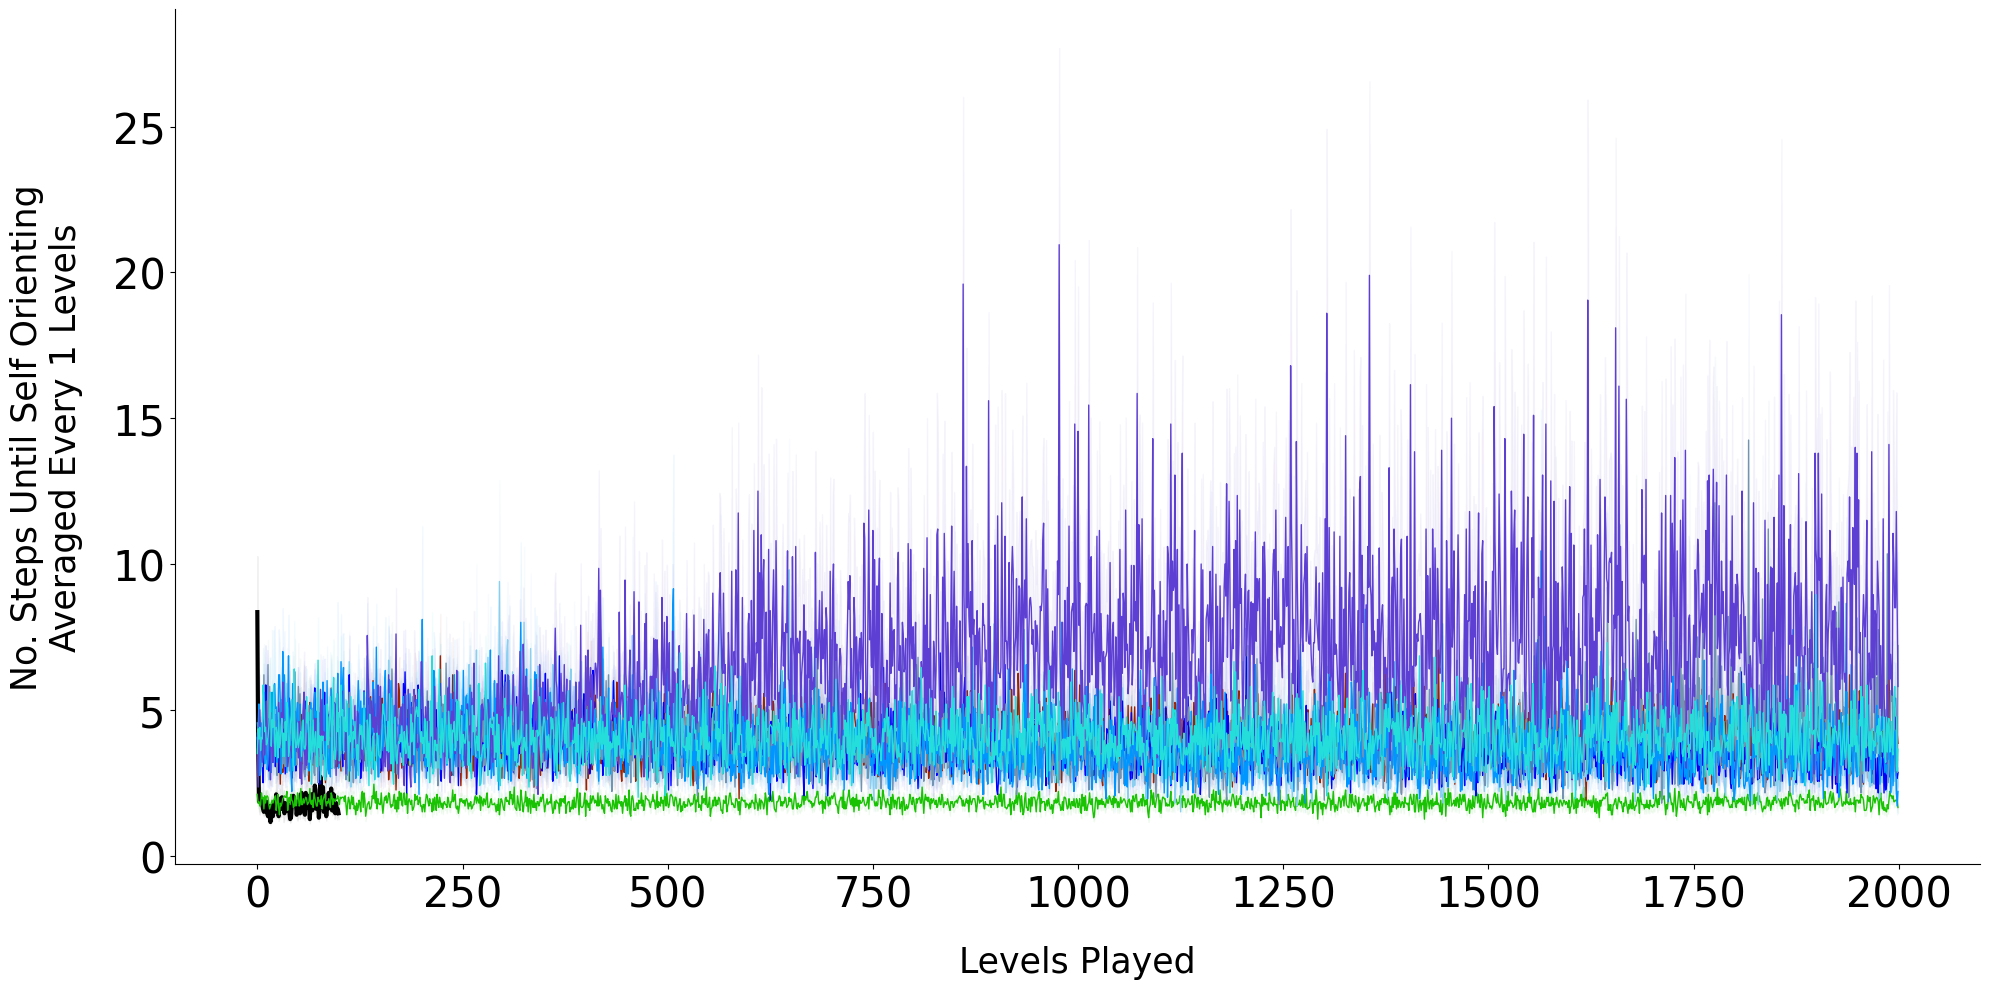

In [51]:
## Plot Action Counts Without Movement -- Only For Logic Game

agent_types = ["human", "self_class", "random", "a2c_training", "trpo_training", "acer_training", "ppo2_training",
               "dqn_training", "option_critic"]
game_types = ["logic_game"]
plot_nm_ac(game_types, agent_types)

In [ ]:
## ----- Plot average distance from the goal for each level
def plot_avg_distance(game_types, agent_types, avg_per_n_steps=50, level=1999):
    for i, game_type in enumerate(game_types):
        avg_distance = get_all_avg_distance(agent_types, game_type, avg_per_n_steps, level)
        xls = [150]
        for xl in xls:
            fig, ax = plt.subplots(figsize=(20, 10))
            ax.set_xlim([0, xl])
            ax.xaxis.label.set_size(25)
            ax.yaxis.label.set_size(25)

            #ax.set_xlabel(xlabel="Step", labelpad=21)
            #ax.set_ylabel(ylabel="Average Distance to Goal", labelpad=21)
            ax.tick_params(axis='both', which='major', labelsize=17)
            ax.xaxis.set_tick_params(labelsize=25)
            ax.yaxis.set_tick_params(labelsize=25)
            #ax.set_title(game_titles[game_type], fontweight='bold', fontsize=25)

            for j, agent in enumerate(agent_types):
                xs = [int(i * avg_per_n_steps) for i in range(0, len(avg_distance[agent + "_m"]))]
                line_width = 4 if agent == 'human' or agent == 'self_class' else 1
                ax.plot(xs, avg_distance[agent + "_m"], color=colors[agent], linewidth=line_width,
                        label=label_dict[agent])
                upper_curve = [avg_distance[agent + '_m'][i] + avg_distance[agent + '_se'][i] for i in
                               range(len(avg_distance[agent + '_m']))]
                lower_curve = [avg_distance[agent + '_m'][i] - avg_distance[agent + '_se'][i] for i in
                               range(len(avg_distance[agent + '_m']))]
                x = [int(i * avg_per_n_steps) for i in range(0, len(avg_distance[agent + "_m"]))]
                ax.fill_between(x, lower_curve, upper_curve, alpha=0.08, color=colors[agent])

            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

            plt.tight_layout()
            plt.show()

            path = './plots/{}/{}/'.format(game_type, 'curves')
            if not os.path.exists(path):
                os.makedirs(path)

            fig.savefig(path + '{}_distance_{}{}{}.pdf'.format(xl, game_type, avg_per_n_steps, level), format='pdf')


def get_all_avg_distance(agent_types, game_type, avg_per_n_steps, level=0):
    # Check if saved data exists
    fpath = './plotting_data/dist_' + game_type + "_batchSize=" + str(avg_per_n_steps) + "level={}".format(
        str(level)) + ".pickle"
    if exists(fpath):
        return pickle.load(open(fpath, 'rb'))

    stats = {}
    for agent in agent_types:
        print(agent + "_m")
        stats[agent + "_m"], stats[agent + "_se"] = get_avg_distance(agent, game_type, avg_per_n_steps, level)

    # Save data
    with open(fpath, 'wb') as f:
        pickle.dump(stats, f)

    return stats


# Ignore avg_per_n_steps here, as it does not mean anything
def get_avg_distance(agent_type, game_type, avg_per_n_steps, level=0):
    if avg_per_n_steps != 1:
        print("Batch size should be 1")
        return
    files = glob.glob("../data/" + game_type + "/" + agent_type + "/*/*.json")

    if len(files) == 0:
        files = glob.glob("../data/" + game_type + "/" + agent_type + "/*.json")

    all_seeds = []
    curr_file_count = 0

    if agent_type not in ["human", "random"]:
        files = [x for x in files if int(x.split("/")[-1][6:-5]) <= 1900]

    sorted_files = sorted(files, key=os.path.getmtime if agent_type == 'human' else get_seed_num_and_iter)

    if agent_type != 'human':
        if level == 1:
            sorted_files = [sorted_files[j] for j in range(0, len(files), 20)]
        elif level == 1999:  # Get the files that only contain the last level
            sf = []
            for j in range(0, len(files), 20):
                sf.append(sorted_files[j - 1])
            sorted_files = sf

    file_amt = len(sorted_files)
    level = level % 100

    # For each seed/subject:
    for i, file in enumerate(sorted_files):
        print("Getting... ", file)
        data = json.load(open(file))
        self_locs = data.get("data")["self_locs"]

        #level_amt = 100
        action_amt = len(self_locs[level][0])

        # Store distance to goal at every action for a particular seed
        distances = [0 for y in range(action_amt)]

        if len(self_locs[level]) == 0:
            continue

        # In each action:
        for action_index in range(action_amt):
            x = self_locs[level][0][action_index]
            y = self_locs[level][1][action_index]

            if x == 0:
                print("?")

            if game_type == "logic_game":
                distances[action_index] = abs(x - 4) + abs(y - 4)

                if (abs(x - 4) + abs(y - 4)) > 6:
                    print("how?")
            else:
                distances[action_index] = abs(x - 10) + abs(y - 10)

        curr_file_count += 1
        all_seeds.append(distances)

    all_seeds = pd.DataFrame(all_seeds).fillna(0)

    if agent_type == 'human':
        if game_type == "logic_game":
            all_seeds.insert(loc=0, value=pd.DataFrame([6 for i in range(file_amt)]),
                            column=-1)  # Set starting distance (8)
        else:
            all_seeds.insert(loc=0, value=pd.DataFrame([8 for i in range(file_amt)]),
                            column=-1)  # Set starting distance (8)

    seed_average = []
    seed_sem = []
    for column in all_seeds:
        seed_average.append(np.mean(list(all_seeds[column]), axis=0))
        seed_sem.append((pd.DataFrame(list(all_seeds[column]))).sem(axis=0))

    curr_avg_data = pd.DataFrame(seed_average).T
    curr_sem_data = pd.DataFrame(seed_sem).T

    if agent_type != 'human':  # AI
        seed_mean = np.array(
            [curr_avg_data[column].groupby(curr_avg_data.index // avg_per_n_steps).mean() for column in
             curr_avg_data]).reshape(
            int(curr_avg_data.shape[1] * 1 / avg_per_n_steps))
        s_sem = np.array(
            [curr_sem_data[column].groupby(curr_sem_data.index // avg_per_n_steps).mean() for column in
             curr_sem_data]).reshape(
            int(curr_sem_data.shape[1] * 1 / avg_per_n_steps))
    else:
        temp = np.asarray(curr_avg_data).T
        avg_ma = [temp[i:i + avg_per_n_steps].mean() for i in range(0, curr_avg_data.shape[1] - avg_per_n_steps + 1, avg_per_n_steps)]

        temp = np.asarray(curr_sem_data).T
        avg_se = [temp[i:i + avg_per_n_steps].mean() for i in range(0, curr_sem_data.shape[1] - avg_per_n_steps + 1, avg_per_n_steps)]

        seed_mean = np.array(avg_ma).reshape(int(curr_avg_data.shape[1] / avg_per_n_steps))
        s_sem = np.array(avg_se).reshape(int(curr_sem_data.shape[1] / avg_per_n_steps))

    return seed_mean, s_sem

In [ ]:
agent_types = ["human", "self_class", "random", "a2c_training", "trpo_training", "acer_training", "ppo2_training",
               "dqn_training", "option_critic", "keep_close"]
game_types = [
    "change_agent_game", ]  #"contingency_game_shuffled_1"] #, "contingency_game", "change_agent_game", "contingency_game_shuffled_100", "contingency_game_shuffled_200"
plot_avg_distance(game_types, agent_types, avg_per_n_steps=1, level=1)
plot_avg_distance(game_types, agent_types, avg_per_n_steps=1, level=1999)